In [1]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid, save_image
import matplotlib.pyplot as plt
import numpy as np
import gc
from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gc.collect()
torch.cuda.empty_cache()

In [ ]:
!gdown --id 1ibjbccZPik-ramrZjYDVAXILJ6sna9g3

In [ ]:
!unzip /content/img_align_celeba.zip -d /content/celeba_data > /dev/null 2>&1

In [ ]:
transform = transforms.Compose([
    transforms.CenterCrop(140),
    transforms.Resize(64),
    transforms.ToTensor(),
])

data_path = "/content/celeba_data/"
dataset = ImageFolder(root=data_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=2)

In [3]:
class CelebADataset(Dataset):
    def __init__(self, root_dir, image_size=64):
        self.root_dir = root_dir
        self.image_files = sorted(os.listdir(root_dir))
        self.transform = transforms.Compose([
            transforms.CenterCrop(140),
            transforms.Resize(image_size),
            transforms.ToTensor(),
        ])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.image_files[idx])
        image = Image.open(img_path).convert("RGB")
        return self.transform(image)

image_folder = "/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba"
dataset = CelebADataset(image_folder, image_size=64)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=2)

images = next(iter(dataloader))
print("Sample batch shape:", images.shape)

Sample batch shape: torch.Size([64, 3, 64, 64])


In [4]:
class Generator(nn.Module):
    def __init__(self, noise_dim):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(noise_dim, 4 * 4 * 1024),
            nn.ReLU(True),
            nn.Unflatten(1, (1024, 4, 4)),
            nn.ConvTranspose2d(1024, 512, 4, 2, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 3, 4, 2, 1),
            nn.Tanh()
        )
    def forward(self, x):
        return self.main(x)

In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, 4, stride=2, padding=1),   # 32x32
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, stride=2, padding=1), # 16x16
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, stride=2, padding=1), # 8x8
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, stride=2, padding=1), # 4x4
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Flatten(),
            nn.Linear(4*4*512, 1)
        )

    def forward(self, x):
        return self.main(x)

In [6]:
loss_fn = nn.BCEWithLogitsLoss()

In [7]:
noise_dim = 100

generator = Generator(noise_dim).to(device)
discriminator = Discriminator().to(device)

In [24]:
generator_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
start_epoch = 0
os.makedirs("checkpoints", exist_ok=True)

generator_checkpoint_path = "checkpoints/generator_last_checkpoint.pth"
discriminator_checkpoint_path = "checkpoints/discriminator_last_checkpoint.pth"
if os.path.exists(generator_checkpoint_path):
    generator_checkpoint = torch.load(generator_checkpoint_path, map_location=device)
    discriminator_checkpoint = torch.load(discriminator_checkpoint_path, map_location=device)
    generator.load_state_dict(generator_checkpoint["model_state_dict"])
    discriminator.load_state_dict(discriminator_checkpoint["model_state_dict"])
    generator_optimizer.load_state_dict(generator_checkpoint["optimizer_state_dict"])
    discriminator_optimizer.load_state_dict(discriminator_checkpoint["optimizer_state_dict"])
    start_epoch = generator_checkpoint["epoch"] + 1
    print(f"Resuming from epoch {start_epoch}")
else:
    print("Starting training from scratch.")

Resuming from epoch 10


In [25]:
num_epochs = 20
gen_losses = []
disc_losses = []
for epoch in range(start_epoch, num_epochs):
    generator.train()
    discriminator.train()

    for batch in dataloader:

        real_images = batch.to(device)
        
        discriminator_optimizer.zero_grad()

        real_labels = torch.ones(real_images.size(0), 1, device=device)
        real_outputs = discriminator(real_images)
        real_loss = loss_fn(real_outputs, real_labels)

        noise = torch.randn(real_images.size(0), noise_dim, device=device)
        fake_images = generator(noise)
        fake_labels = torch.zeros(real_images.size(0), 1, device=device)
        fake_outputs = discriminator(fake_images.detach())
        fake_loss = loss_fn(fake_outputs, fake_labels)

        d_loss = real_loss + fake_loss
        d_loss.backward()
        discriminator_optimizer.step()

        generator_optimizer.zero_grad()
        fake_labels = torch.ones(real_images.size(0), 1, device=device)
        fake_outputs = discriminator(fake_images)
        g_loss = loss_fn(fake_outputs, fake_labels)
        g_loss.backward()
        generator_optimizer.step()

        gen_losses.append(g_loss.item())
        disc_losses.append(d_loss.item())

    torch.save({
        'epoch': epoch,
        'model_state_dict': generator.state_dict(),
        'optimizer_state_dict': generator_optimizer.state_dict(),
        'loss': g_loss,
    }, f"checkpoints/generator_epoch_{epoch}.pth")

    torch.save({
        'epoch': epoch,
        'model_state_dict': discriminator.state_dict(),
        'optimizer_state_dict': discriminator_optimizer.state_dict(),
        'loss': d_loss,
    }, f"checkpoints/discriminator_epoch_{epoch}.pth")

    torch.save({
        "epoch": epoch,
        "model_state_dict": generator.state_dict(),
        "optimizer_state_dict": generator_optimizer.state_dict(),
        "loss": g_loss,
    }, "checkpoints/generator_last_checkpoint.pth")

    torch.save({
        "epoch": epoch,
        "model_state_dict": discriminator.state_dict(),
        "optimizer_state_dict": discriminator_optimizer.state_dict(),
        "loss": d_loss,
    }, "checkpoints/discriminator_last_checkpoint.pth")

    avg_gen_loss = sum(gen_losses[-len(dataloader) :]) / len(dataloader)
    avg_disc_loss = sum(disc_losses[-len(dataloader) :]) / len(dataloader)
    print(f"Epoch {epoch}, Generator Loss: {avg_gen_loss:.4f}, Discriminator Loss: {avg_disc_loss:.4f}")

Epoch 10, Generator Loss: 5.1208, Discriminator Loss: 0.2593
Epoch 11, Generator Loss: 5.1798, Discriminator Loss: 0.2627
Epoch 12, Generator Loss: 5.2181, Discriminator Loss: 0.2375
Epoch 13, Generator Loss: 5.1831, Discriminator Loss: 0.2663
Epoch 14, Generator Loss: 5.2444, Discriminator Loss: 0.2355
Epoch 15, Generator Loss: 5.2850, Discriminator Loss: 0.2493
Epoch 16, Generator Loss: 5.1831, Discriminator Loss: 0.2663
Epoch 17, Generator Loss: 5.2852, Discriminator Loss: 0.2406
Epoch 18, Generator Loss: 5.3657, Discriminator Loss: 0.2415
Epoch 19, Generator Loss: 5.3227, Discriminator Loss: 0.2396


In [26]:
with open('generator_losses.txt', 'w') as file:
    for loss in gen_losses:
        file.write(f"{loss}\n")

with open('discriminator_losses.txt', 'w') as file:
    for loss in disc_losses:
        file.write(f"{loss}\n")

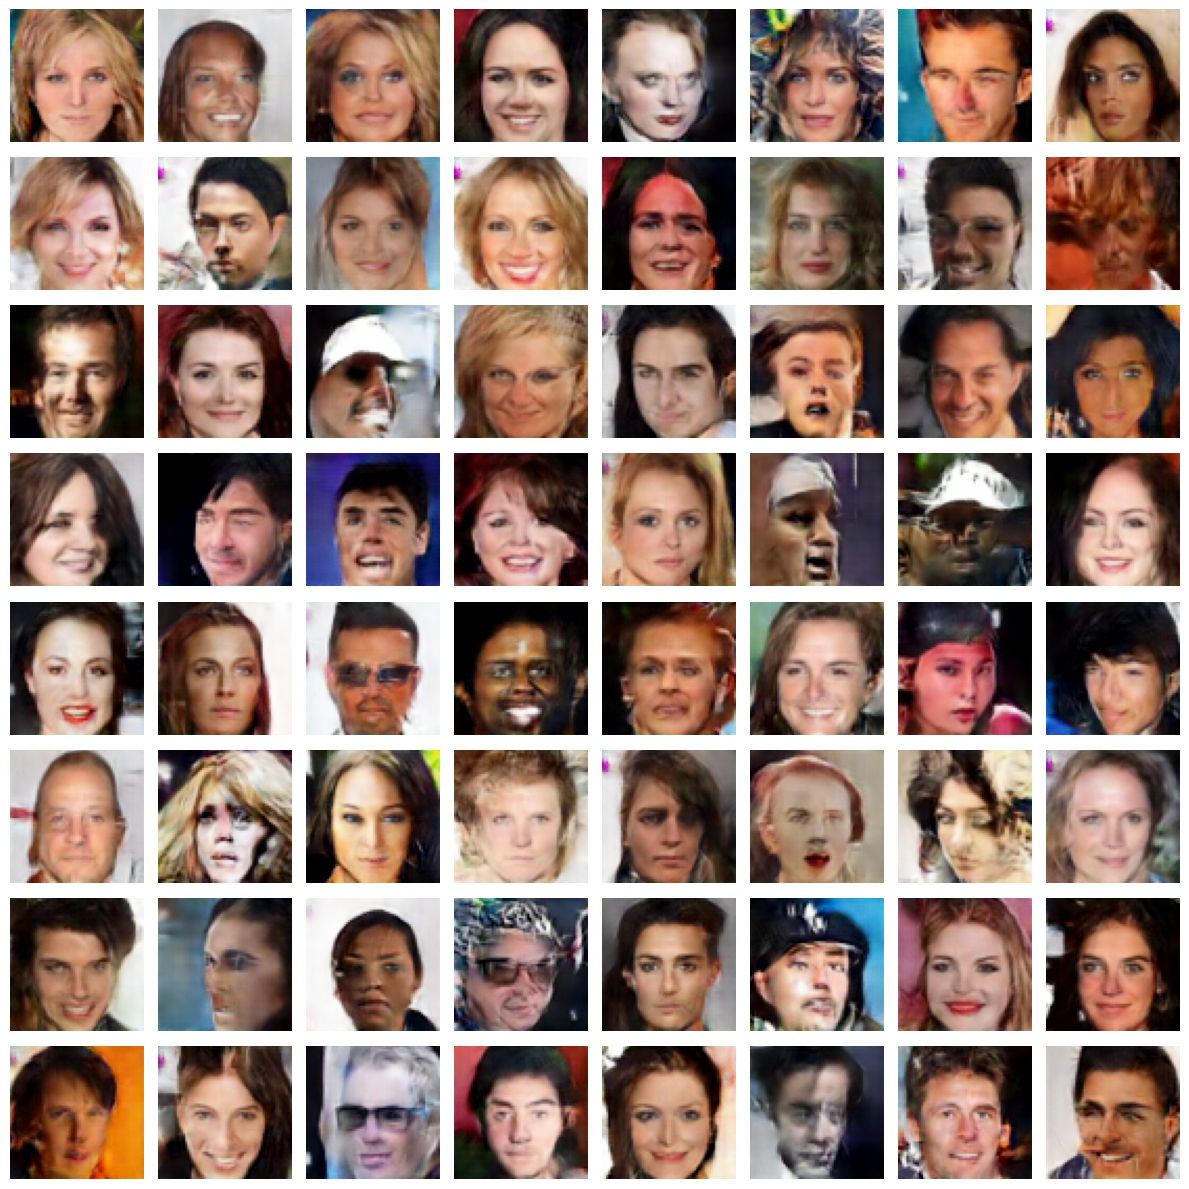

In [27]:
generator.eval()

with torch.no_grad():
    z = torch.randn(64, noise_dim).to(device)
    samples = generator(z).cpu()

grid = make_grid(samples, nrow=8, normalize=True)
save_image(grid, "generated_images.png")

fig, axes = plt.subplots(8, 8, figsize=(12, 12))
for i, img in enumerate(samples):
    row, col = divmod(i, 8)
    img_np = img.cpu().permute(1, 2, 0).numpy()
    axes[row, col].imshow(np.clip(img_np, 0, 1))
    axes[row, col].axis('off')
plt.tight_layout()
plt.show()

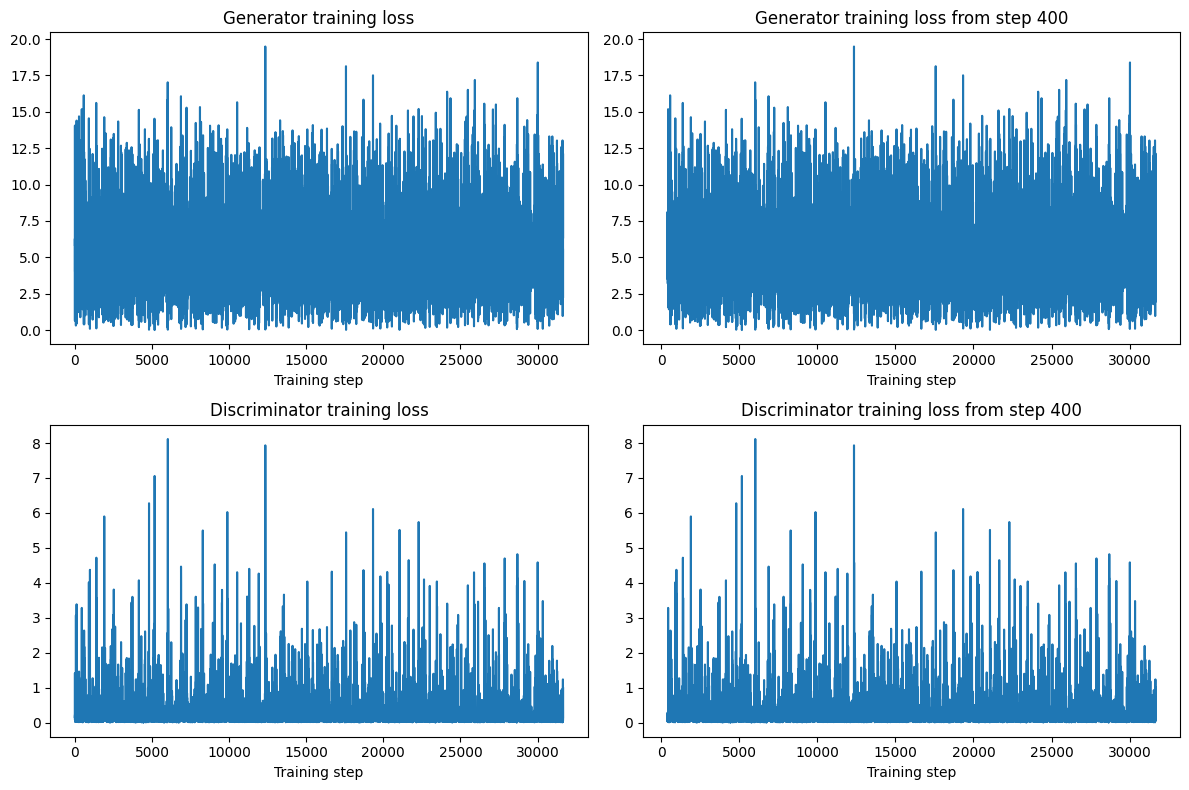

In [28]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

axs[0, 0].plot(gen_losses)
axs[0, 0].set_title("Generator training loss")
axs[0, 0].set_xlabel("Training step")

axs[0, 1].plot(range(400, len(gen_losses)), gen_losses[400:])
axs[0, 1].set_title("Generator training loss from step 400")
axs[0, 1].set_xlabel("Training step")

axs[1, 0].plot(disc_losses)
axs[1, 0].set_title("Discriminator training loss")
axs[1, 0].set_xlabel("Training step")

axs[1, 1].plot(range(400, len(disc_losses)), disc_losses[400:])
axs[1, 1].set_title("Discriminator training loss from step 400")
axs[1, 1].set_xlabel("Training step")

plt.tight_layout()
plt.show()
